In [1]:
import vtk
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.spatial import KDTree
from scipy.interpolate import RegularGridInterpolator
from scipy.signal import savgol_filter
import pygmt
import parallel_curves
import importlib
import pandas as pd
import h5py
from scipy.special import erf
import matplotlib.colors as mcolors
from scipy.interpolate import interp1d
import matplotlib.patches as patches

In [2]:
def log_RMS_misfit(naif_data, pylith_data):
    N = len(pylith_data)
    log_difference = (np.log10(pylith_data) - np.log10(naif_data))**2
    log_rms_error = np.sqrt(1/N * np.sum(log_difference))
    return log_rms_error

def log_absolute_misfit(naif_data, pylith_data):
    N = len(pylith_data)
    log_difference = abs(np.log10(pylith_data) - np.log10(naif_data))
    log_error = 1/N * np.sum(log_difference)
    return log_error

def RMS_misfit(naif_data, pylith_data):
    N = len(pylith_data)
    difference = (pylith_data - naif_data)**2
    rms_error = np.sqrt(1/N * np.sum(difference))
    return rms_error

# Load in Naif et al., Datasets

In [3]:
porosity = pd.read_excel('porosity_SERPENT_outerrise.xlsx', header=None).to_numpy()
resistivity = pd.read_excel('resistivity_SERPENT_outerrise.xlsx', header=None).to_numpy()

trench_distance = np.flip(np.arange(0, 100.1, 0.1))
depth_resistivity = np.arange(0, 12.75, 0.05)
depth_porosity = np.arange(0, 10., 0.05)

X_POR, Z_POR = np.meshgrid(trench_distance, depth_porosity)
X_RES, Z_RES = np.meshgrid(trench_distance, depth_resistivity)

# We do not include the sediment layer in our model. Set the resistivity of the sediments 
# in the Naif dataset to NAN's so that it doesn't impact our comparison. They define the
# sediment layer as being below a resistivity of 3.5 ohm meter. This occurs at roughly a
# depth of 500 m.
# basement_resistivity = 3.5
# resistivity[resistivity <= 3.5] = np.nan
X_POR = X_POR[10:, :]
Z_POR = Z_POR[10:, :] - 0.5
porosity = porosity[10:, :]

X_POR = X_POR[:, 0:-50]
Z_POR = Z_POR[:, 0:-50]
porosity = porosity[:, 0:-50]

X_RES = X_RES[10:, :]
Z_RES = Z_RES[10:, :] - 0.5
resistivity = resistivity[10:, :]

X_RES = X_RES[:, 0:-50]
Z_RES = Z_RES[:, 0:-50]
resistivity = resistivity[:, 0:-50]

# Try doing the depth averaged binned calculation for the Porosity (Figure 9 from Naif et al.,)

In [4]:
def depth_average_porosity(base_x, bin_sizes, X_POR, Z_POR, POROSITY):
    '''
    base_x = the initial value to start binning the data (double)
    bin_sizes = an array of doubles that specifies the width of the bins. The first bin will start
                at base_x, and the subsequent bins will be shifted by the size of the previous bins.
    X_POR  = uniform mesh that specifies the x-values of the grid
    Z_POR  = uniform mesh that specifies the z-values of the grid
    POROSITY = uniform mesh that specifies the porosity values on the grid

    Returns:
    An array (object) that contains the depth averaged porosity within each bin, and an array that
    specifies the depths of the depth averaging.
    '''
    # Create an array to store the depth averages. There must be the same
    # number of depth averaged curves as there are the number of bins.
    depth_averaged_por = np.zeros(len(bin_sizes), dtype=object)
    z_vals_for_bins = np.unique(Z_POR.flatten())
    
    for i in range(len(bin_sizes)):
        average_por_at_z_vals = np.zeros(len(z_vals_for_bins))
        for j in range(len(z_vals_for_bins)):
    
            por_indices = np.where( (X_POR.flatten() >= base_x) & (X_POR.flatten() <= base_x + bin_sizes[i]) & (Z_POR.flatten() == z_vals_for_bins[j]) )
            por_at_current_z = POROSITY.flatten()[por_indices]
            average_por_at_z_vals[j] = np.average(por_at_current_z)
    
        depth_averaged_por[i] = average_por_at_z_vals
        base_x += bin_sizes[i]

    return z_vals_for_bins, depth_averaged_por

In [5]:
base_x = 5
bin_sizes = np.array([15, 20, 20, 20, 20])
z_vals_for_bins, depth_averaged_por = depth_average_porosity(base_x, bin_sizes, X_POR, Z_POR, porosity)
into_text_file = np.array([z_vals_for_bins, depth_averaged_por[0]]).T
base_save_dir = "/Users/danieldouglas/src/cig/Outer-Rise-Faulting-PyLith/CAM_outerrise/PUBLICATION_MODELS/data_files/"
np.savetxt(fname=base_save_dir + "trench_bin_porosity.txt", X=into_text_file)

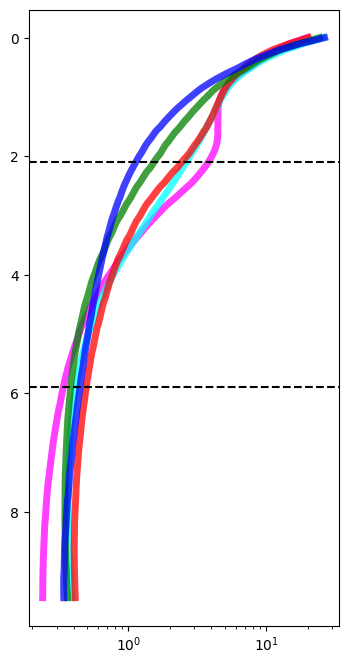

In [6]:
plt.figure(dpi=100, figsize=(4, 8))
colors = np.array(["magenta", "cyan", "red", "green", "blue"])
for i in range(len(depth_averaged_por)):
    # if i == 2:
        plt.plot(depth_averaged_por[i] * 100, z_vals_for_bins, lw=5, alpha=0.75, color=colors[i])
plt.xscale('log')
plt.axhline(2.1, ls='--', c='black')
plt.axhline(5.9, ls='--', c='black')
plt.gca().invert_yaxis()

In [7]:
farthest_depth_ave_por_into_text_file = np.array([z_vals_for_bins, depth_averaged_por[-1]]).T
base_dir = "/Users/danieldouglas/src/cig/Outer-Rise-Faulting-PyLith/CAM_outerrise/PUBLICATION_MODELS/data_files/"
np.savetxt(fname=base_dir + "ave_NAIF_porosity.txt", X=farthest_depth_ave_por_into_text_file)

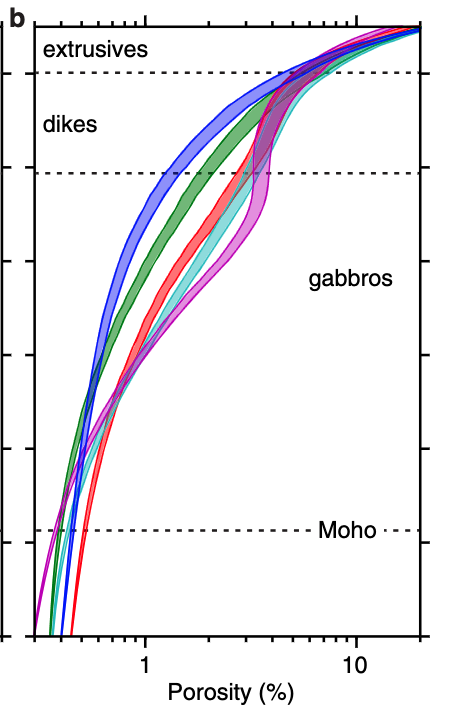

In [8]:
base_dir = "/Users/danieldouglas/src/cig/Outer-Rise-Faulting-PyLith/CAM_outerrise/PUBLICATION_MODELS/"
perm_model = "hatakeyama/"

pylith_models = np.array(["step01_no_faults_no_flexure",
                          "step03_faults_no_flexure",
                          "step02_no_faults_with_flexure",
                          "step04_faults_with_flexure_2.5x", 
                          "step04_faults_with_flexure_5x",
                          "step04_faults_with_flexure_10x",
                          "step04_faults_with_flexure_25x",
                          "step04_faults_with_flexure_100x"])

# pylith_models = np.array(["step05_rupture_faults_no_perm_faults_low_tol"])

porosity_file = np.loadtxt(fname=base_dir + "data_files/ave_NAIF_porosity.txt")
depth_averages_for_models_ha = np.zeros(len(pylith_models), dtype=object)

for i in range(len(pylith_models)):
    data_filename  = pylith_models[i] + "-subducting.h5"
    data_file_path = base_dir + perm_model + pylith_models[i] + '/' + data_filename
    
    with h5py.File(data_file_path, 'r') as f:
        total_porosity = f["vertex_fields"]["porosity"][:]
        total_water_content = f["vertex_fields"]["water_content"][:]
        final_porosity = total_porosity[-1]
        final_water_content = total_water_content[-1]
        
        vertices = f["geometry/vertices"]
        x_vals = vertices[:, 0]
        y_vals = vertices[:, 1]
    
        pylith_porosity = np.zeros(len(y_vals))
        for j in range(len(pylith_porosity)):
            depth_index = np.abs(y_vals[j] + porosity_file[:, 0] * 1e3).argmin()
            pylith_porosity[j] = porosity_file[:, 1][depth_index] + final_water_content[j][0]

        outerrise_x_vals   = abs(x_vals[np.where( (x_vals <= 0) & (y_vals >= -9.5e3) )] / 1e3)
        outerrise_y_vals   = abs(y_vals[np.where( (x_vals <= 0) & (y_vals >= -9.5e3) )] / 1e3)
        
        outerrise_porosity   = final_porosity[np.where( (x_vals <= 0) & (y_vals >= -9.5e3) )]
        # outerrise_porosity   = pylith_porosity[np.where( (x_vals <= 0) & (y_vals >= -9.5e3) )]

        pylith_naif_porosity = np.zeros(len(Z_POR.flatten()))
        naif_KDTREE = KDTree(np.c_[outerrise_x_vals, outerrise_y_vals])
        
        for j in range(len(pylith_naif_porosity)):
            dd, ii = naif_KDTREE.query([X_POR.flatten()[j], Z_POR.flatten()[j]])
            pylith_naif_porosity[j] = outerrise_porosity.flatten()[ii]

    z_vals_for_bins, depth_averages_for_models_ha[i] = depth_average_porosity(base_x, bin_sizes, X_POR, Z_POR, pylith_naif_porosity)

    print("Finished with model: " + str(i + 1) + " of " + str(len(pylith_models)))

binned_errors_ha = np.zeros(len(depth_averages_for_models_ha), dtype=object)
for i in range(len(binned_errors_ha)):
    binned_errors_ha[i] = np.zeros(len(depth_averages_for_models_ha[i]) - 1)
    for j in range(len(binned_errors_ha[i])):
        binned_errors_ha[i][j] = np.mean(np.abs(depth_averages_for_models_ha[i][j] - depth_averaged_por[j]) / depth_averaged_por[j])

Finished with model: 1 of 8
Finished with model: 2 of 8
Finished with model: 3 of 8
Finished with model: 4 of 8
Finished with model: 5 of 8
Finished with model: 6 of 8
Finished with model: 7 of 8
Finished with model: 8 of 8


In [9]:
for i in range(len(depth_averages_for_models_ha)):
    test = 0
    for j in range(len(depth_averages_for_models_ha[i]) - 1):
        test += log_absolute_misfit(depth_averaged_por[j], depth_averages_for_models_ha[i][j])
        if i == 1:
            print(log_absolute_misfit(depth_averaged_por[j], depth_averages_for_models_ha[i][j]))
    print(test)

0.47003399659491923
0.19322467372826543
0.11512805423144176
0.10490494047982077
0.0681796304679139
0.4814372989074418
0.37226548765119494
0.372391543657253
0.37562259566878
0.38876283455305316
0.41583798207421063
0.4536764314769249


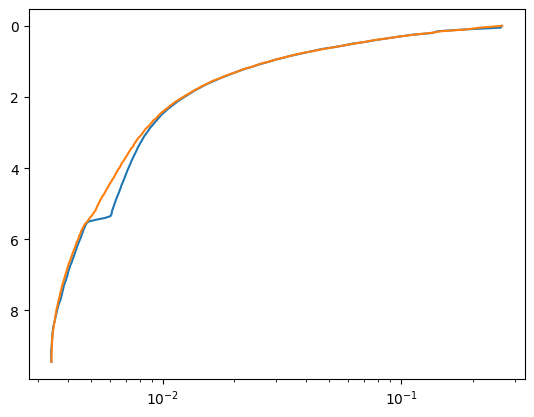

In [10]:
plt.plot(depth_averages_for_models_ha[1][0], z_vals_for_bins)
plt.plot(depth_averages_for_models_ha[1][-1], z_vals_for_bins)
plt.xscale('log')
plt.gca().invert_yaxis()

In [38]:
base_dir = "/Users/danieldouglas/src/cig/Outer-Rise-Faulting-PyLith/CAM_outerrise/PUBLICATION_MODELS/"
perm_model = "hatakeyama_mid_perm/"

pylith_models = np.array(["step01_no_faults_no_flexure",
                          "step03_faults_no_flexure",
                          "step02_no_faults_with_flexure",
                          "step04_faults_with_flexure_2.5x", 
                          "step04_faults_with_flexure_5x",
                          "step04_faults_with_flexure_10x",
                          "step04_faults_with_flexure_25x",
                          "step04_faults_with_flexure_100x"])

# pylith_models = np.array(["step01_no_faults_no_flexure"])
# pylith_models = np.array(["step02_no_faults_with_flexure"])

porosity_file = np.loadtxt(fname="/Users/danieldouglas/src/cig/Outer-Rise-Faulting-PyLith/CAM_outerrise/PUBLICATION_MODELS/data_files/NAIF_porosity.txt")
depth_averages_for_models_kj = np.zeros(len(pylith_models), dtype=object)

for i in range(len(pylith_models)):
    data_filename  = pylith_models[i] + "-subducting.h5"
    data_file_path = base_dir + perm_model + pylith_models[i] + '/' + data_filename
    
    with h5py.File(data_file_path, 'r') as f:
        total_porosity = f["vertex_fields"]["porosity"][:]
        total_water_content = f["vertex_fields"]["water_content"][:]
        final_porosity = total_porosity[-1]
        final_water_content = total_water_content[-1]
        # final_water_content[final_water_content < -0.05] = 0
        
        vertices = f["geometry/vertices"]
        x_vals = vertices[:, 0]
        y_vals = vertices[:, 1]
    
        pylith_porosity = np.zeros(len(y_vals))
        for j in range(len(pylith_porosity)):
            depth_index = np.abs(y_vals[j] + porosity_file[:, 0] * 1e3).argmin()
            pylith_porosity[j] = porosity_file[:, 1][depth_index] + final_water_content[j][0]

        outerrise_x_vals   = abs(x_vals[np.where( (x_vals <= 0) & (y_vals >= -9.5e3) )] / 1e3)
        outerrise_y_vals   = abs(y_vals[np.where( (x_vals <= 0) & (y_vals >= -9.5e3) )] / 1e3)
        
        outerrise_porosity   = final_porosity[np.where( (x_vals <= 0) & (y_vals >= -9.5e3) )]
        # outerrise_porosity   = pylith_porosity[np.where( (x_vals <= 0) & (y_vals >= -9.5e3) )]

        pylith_naif_porosity = np.zeros(len(Z_POR.flatten()))
        naif_KDTREE = KDTree(np.c_[outerrise_x_vals, outerrise_y_vals])
        
        for j in range(len(pylith_naif_porosity)):
            dd, ii = naif_KDTREE.query([X_POR.flatten()[j], Z_POR.flatten()[j]])
            pylith_naif_porosity[j] = outerrise_porosity.flatten()[ii]

    z_vals_for_bins, depth_averages_for_models_kj[i] = depth_average_porosity(base_x, bin_sizes, X_POR, Z_POR, pylith_naif_porosity)

    print("Finished with model: " + str(i + 1) + " of " + str(len(pylith_models)))

binned_errors_kj = np.zeros(len(depth_averages_for_models_kj), dtype=object)
for i in range(len(depth_averages_for_models_kj)):
    binned_errors_kj[i] = np.zeros(len(depth_averages_for_models_kj[i]) - 1)
    for j in range(len(binned_errors_kj[i])):
        binned_errors_kj[i][j] = np.mean(np.abs(depth_averages_for_models_kj[i][j] - depth_averaged_por[j]) / depth_averaged_por[j])

Finished with model: 1 of 8
Finished with model: 2 of 8
Finished with model: 3 of 8
Finished with model: 4 of 8
Finished with model: 5 of 8
Finished with model: 6 of 8
Finished with model: 7 of 8
Finished with model: 8 of 8


# Make Figure 3 for Publication

In [40]:
test = np.zeros(len(depth_averages_for_models_kj))

# for i in range(len(depth_averages_for_models_kj)):
#     for j in range(len(depth_averages_for_models_kj[i]) - 1):
#         test[i] += log_absolute_misfit(depth_averaged_por[j], depth_averages_for_models_kj[i][j])

for i in range(len(depth_averages_for_models_kj)):
    for j in range(len(depth_averages_for_models_kj[i]) - 1):
        test[i] += log_RMS_misfit(depth_averaged_por[j], depth_averages_for_models_kj[i][j])

# for i in range(len(depth_averages_for_models_kj)):
#     for j in range(len(depth_averages_for_models_kj[i]) - 1):
#         test[i] += RMS_misfit(depth_averaged_por[j], depth_averages_for_models_kj[i][j])
test

array([0.65348662, 0.65600316, 0.60061538, 0.60167441, 0.60674994,
       0.61116935, 0.61544828, 0.61869375])

In [35]:
test = np.zeros(len(depth_averages_for_models_ha))

# for i in range(len(depth_averages_for_models_kj)):
#     for j in range(len(depth_averages_for_models_kj[i]) - 1):
#         test[i] += log_absolute_misfit(depth_averaged_por[j], depth_averages_for_models_kj[i][j])

for i in range(len(depth_averages_for_models_ha)):
    for j in range(len(depth_averages_for_models_ha[i]) - 1):
        test[i] += log_RMS_misfit(depth_averaged_por[j], depth_averages_for_models_ha[i][j])

# for i in range(len(depth_averages_for_models_kj)):
#     for j in range(len(depth_averages_for_models_kj[i]) - 1):
#         test[i] += RMS_misfit(depth_averaged_por[j], depth_averages_for_models_kj[i][j])
test

array([0.61651971, 0.62490163, 0.46321065, 0.46325271, 0.46597517,
       0.47550359, 0.50052289, 0.54337957])

In [41]:
panel_width  = 12.0
panel_height = 8.0

panel_dim = [0, 0, panel_width, panel_height]

fig = plt.figure(dpi=100, figsize=(panel_width, panel_height))
main_ax = plt.axes(panel_dim)

for spine in main_ax.spines.values():
    spine.set_linewidth(15)

# The errors were calculated using the ABSOLUTE LOG MISFIT, and copied
# manually into the arrays below.
# The indices of the error arrays are:
# 0: No faults, no flexure
# 1: Faults (25x permeability), no flexure
# 2: No faults, with flexure
# 3: Faults (2.5x permeability), with flexure
# 4: Faults (5x permeability), with flexure
# 5: Faults (7.5x permeability), with flexure
# 6: Faults (10x permeability), with flexure
# 7: Faults (25x permeability), with flexure

hatakeyama_low_errors  = np.array([0.61651971, 0.62490163, 0.46321065, 0.46325271,\
                                   0.46597517, 0.47550359, 0.50052289, 0.54337957])
hatakeyama_high_errors = np.array([0.65348662, 0.65600316, 0.60061538, 0.60167441, \
                                   0.60674994, 0.61116935, 0.61544828, 0.61869375])
kuang_jiao_errors      = np.array([0.66089194, 0.66065577, 0.6201892, 0.62021343, \
                                   0.620529, 0.62075678, 0.62094497, 0.621077])
power_law_errors       = np.array([0.66070083, 0.66064111, 0.62057284, 0.62057563, \
                                   0.62080093, 0.6209431 , 0.62104376, 0.62110363])

model_type_x      = np.arange(1, 9, 1)
kuang_jiao_y      = np.zeros(len(model_type_x)) + 1
power_law_y       = np.zeros(len(model_type_x)) + 2
hatakeyama_high_y = np.zeros(len(model_type_x)) + 3
hatakeyama_low_y  = np.zeros(len(model_type_x)) + 4

rect = patches.Rectangle((0.5, 0.5), 2, 5, linewidth=1, edgecolor='black', facecolor='black', alpha=0.1)
main_ax.add_patch(rect)
main_ax.axvline(2.5, lw=30, c='k')

levels = np.linspace(0.46, 0.66, 21)
norm = mcolors.BoundaryNorm(levels, ncolors=plt.cm.jet.N, clip=True)

cax = fig.add_axes([0, -3, panel_width, 0.5])

im = main_ax.scatter(model_type_x, kuang_jiao_y, c=kuang_jiao_errors, 
                     s=200000, cmap="jet", edgecolor="black", norm=norm, 
                     marker='o', lw=10, zorder=100000)

cbar = fig.colorbar(im, cax=cax, orientation='horizontal', norm=norm)
cbar.set_label('$\chi$ Misfit', size=400)
cbar.set_ticks([0.46, 0.51, 0.56, 0.61, 0.66])
cbar.ax.tick_params(which="major", labelsize=250, length=200, width=25)
cbar.ax.tick_params(which="minor", labelsize=0, length=75, width=10) 

main_ax.scatter(model_type_x, power_law_y, c=power_law_errors, 
                     s=200000, cmap="jet", edgecolor="black", norm=norm, 
                     marker='o', lw=10, zorder=100000)
main_ax.scatter(model_type_x, hatakeyama_high_y, c=hatakeyama_high_errors, 
                     s=200000, cmap="jet", edgecolor="black", norm=norm, 
                     marker='o', lw=10, zorder=100000)
main_ax.scatter(model_type_x, hatakeyama_low_y, c=hatakeyama_low_errors, 
                     s=200000, cmap="jet", edgecolor="black", norm=norm, 
                     marker='o', lw=10, zorder=100000)

# main_ax.scatter(model_type_x, kuang_jiao_y, c=kuang_jiao_errors, s=200000, vmin=0.4, vmax=0.55, cmap="plasma", edgecolor="black", norm=norm)
# main_ax.scatter(model_type_x, power_law_y, c=power_law_errors, s=200000, vmin=0.4, vmax=0.55)
# main_ax.scatter(model_type_x, hatakeyama_high_y, c=hatakeyama_high_errors, s=200000, vmin=0.4, vmax=0.55)
# main_ax.scatter(model_type_x, hatakeyama_low_y, c=hatakeyama_low_errors, s=200000, vmin=0.4, vmax=0.55)

main_ax.set_xlim(0.75, 8.25)
main_ax.set_ylim(0.75, 4.25)

main_ax.tick_params(axis="both", length=200, width=25)
main_ax.set_yticks([1, 2, 3, 4])

# rect = patches.Rectangle((1.75, 3.75), 0.5, 0.5, linewidth=30, edgecolor='black', facecolor='none')
# main_ax.add_patch(rect)

# main_ax.text(0.875, 0, "NF-NF", fontsize=250, rotation=-90)
# main_ax.text(1.875, -0.25, "F25x-NF", fontsize=250, rotation=-90)
# main_ax.text(2.875, 0.15, "NF-F", fontsize=250, rotation=-90)
# main_ax.text(3.875, -0.15, "F2.5x-F", fontsize=250, rotation=-90)
# main_ax.text(4.875, 0, "F5x-F", fontsize=250, rotation=-90)
# main_ax.text(5.875, -0.15, "F7.5x-F", fontsize=250, rotation=-90)
# main_ax.text(6.875, -0.125, "F10x-F", fontsize=250, rotation=-90)
# main_ax.text(7.875, -0.125, "F25x-F", fontsize=250, rotation=-90)

# main_ax.text(0.15, 4, "HA", fontsize=250)
# main_ax.text(0.1, 3.8, "LOW", fontsize=250)

# main_ax.text(0.15, 3, "HA", fontsize=250)
# main_ax.text(0.075, 2.8, "HIGH", fontsize=250)

# main_ax.text(0.2, 1.9, "PL", fontsize=250)

# main_ax.text(0.2, 0.9, "KJ", fontsize=250)

main_ax.text(0.4, 4.75, "a)", fontsize=300)

main_ax.text(8.8, 1.45, "Higher Background", fontsize=300, rotation=-90)
main_ax.text(8.5, 1.75, "Permeability", fontsize=300, rotation=-90)
main_ax.arrow(x=8.45, y=4.25, dx=0.0, dy=-3, width=0.1, clip_on=False, color='black')

main_ax.text(4.7, 4.85, "Higher Fault", fontsize=300)
main_ax.text(4.7, 4.55, "Permeability", fontsize=300)
main_ax.arrow(x=3, y=4.45, dx=4.75, dy=0, width=0.1, clip_on=False, color='black')

main_ax.text(1.0, 4.5, "No Flexure", fontsize=300)

main_ax.text(0, 0.6, "Reference Permeability Model", fontsize=300, rotation=90, fontweight="bold")

main_ax.text(0.4, 0.65, "Model 1", fontsize=235, rotation=90)
main_ax.text(0.4, 1.65, "Model 2", fontsize=235, rotation=90)
main_ax.text(0.4, 2.65, "Model 3", fontsize=235, rotation=90)
main_ax.text(0.4, 3.65, "Model 4", fontsize=235, rotation=90)

main_ax.text(0.875, 0.4, "1x",   fontsize=235, rotation=0)
main_ax.text(1.875, 0.4, "25x",  fontsize=235, rotation=0)
main_ax.text(2.875, 0.4, "1x",   fontsize=235, rotation=0)
main_ax.text(3.875, 0.4, "2.5x", fontsize=235, rotation=0)
main_ax.text(4.875, 0.4, "5x",   fontsize=235, rotation=0)
main_ax.text(5.875, 0.4, "10x", fontsize=235, rotation=0)
main_ax.text(6.875, 0.4, "25x",  fontsize=235, rotation=0)
main_ax.text(7.865, 0.4, "100x",  fontsize=235, rotation=0)

main_ax.text(2.5, 0., "Fault Permeability Enhancement", fontsize=300, rotation=0, fontweight="bold")

plt.savefig("Figures/error_plot.png", bbox_inches="tight")
plt.show()

# PLOT OF MISFIT IN RELATION TO THE TRENCH

In [42]:
no_fault_index = 2
fault_index    = 7
ha_no_faults = np.zeros(len(depth_averages_for_models_ha[no_fault_index]) - 1)
ha_faults = np.zeros(len(depth_averages_for_models_ha[fault_index]) - 1)
kj_no_faults = np.zeros(len(depth_averages_for_models_kj[no_fault_index]) - 1)

for j in range(len(ha_no_faults)):
    ha_no_faults[j] = log_RMS_misfit(depth_averaged_por[j], depth_averages_for_models_ha[no_fault_index][j])
    ha_faults[j]    = log_RMS_misfit(depth_averaged_por[j], depth_averages_for_models_ha[fault_index][j])
    kj_no_faults[j] = log_RMS_misfit(depth_averaged_por[j], depth_averages_for_models_kj[no_fault_index][j])

ha_no_faults = ha_no_faults / np.sum(ha_no_faults) * 100
ha_faults    = ha_faults / np.sum(ha_faults) * 100
kj_no_faults = kj_no_faults / np.sum(kj_no_faults) * 100

In [47]:
panel_width  = 12.0
panel_height = 6.0

panel_dim = [0, 0, panel_width, panel_height]

x_vals = np.array([10, 30, 50, 70])

fig = plt.figure(dpi=100, figsize=(panel_width, panel_height))
main_ax = plt.axes(panel_dim)

for spine in main_ax.spines.values():
    spine.set_linewidth(15)

main_ax.set_xlabel("Distance From The Trench - km", fontsize=280)
main_ax.set_ylabel("% of Misfit", fontsize=280)

main_ax.set_xlim(8, 72)
main_ax.set_ylim(9, 41)

main_ax.set_xticks([10, 30, 50, 70])
main_ax.set_yticks([10, 25, 40])

main_ax.tick_params(axis="both", length=150, width=20, labelsize=200)

main_ax.invert_xaxis() 

main_ax.plot(x_vals, ha_no_faults, lw=60, color="black")
main_ax.plot(x_vals, ha_no_faults, lw=30, color="goldenrod", marker='o', 
             markersize=350, markerfacecolor="goldenrod", markeredgecolor="black", markeredgewidth=20,
             label="Model 4 - No Faults")

main_ax.plot(x_vals, ha_faults, lw=60, color="black")
main_ax.plot(x_vals, ha_faults, lw=30, color="khaki", marker='^', 
             markersize=300, markerfacecolor="khaki", markeredgecolor="black", markeredgewidth=20, 
             label="Model 4 - 100x Faults")

main_ax.plot(x_vals, kj_no_faults, lw=60, color="black")
main_ax.plot(x_vals, kj_no_faults, lw=30, color="plum", marker='*', 
             markersize=300, markerfacecolor="plum", markeredgecolor="black", markeredgewidth=20,
             label="Model 1 - No Faults")

main_ax.legend(loc="upper left", fontsize=250, ncols=2)

main_ax.text(78.5, 28, ".", fontsize=0.1, color="white")

main_ax.text(76.5, 45, "b)", fontsize=300)

plt.savefig("Figures/trench_dist_error_plot.png", bbox_inches="tight")
plt.show()

# KUANG JIAO 

0.15631226193550796

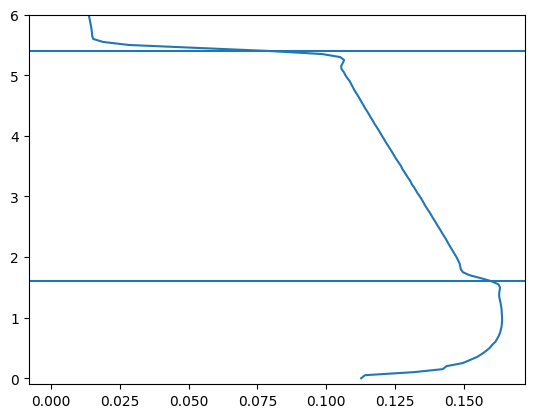

In [119]:
kj_diff = abs(depth_averages_for_models_kj[flexure_index][3] - depth_averages_for_models_kj[no_flexure_index][3])*100
plt.plot(kj_diff, z_vals_for_bins)
plt.axhline(1.6)
plt.axhline(5.4)
plt.ylim(-0.1, 6)

depth_ave_indices = np.where( (z_vals_for_bins <= 1.6) )
# depth_ave_indices = np.where( (z_vals_for_bins >= 1.6) & (z_vals_for_bins <= 5.4) )
np.average(kj_diff[depth_ave_indices])

# HATAKEYAMA FIGURE

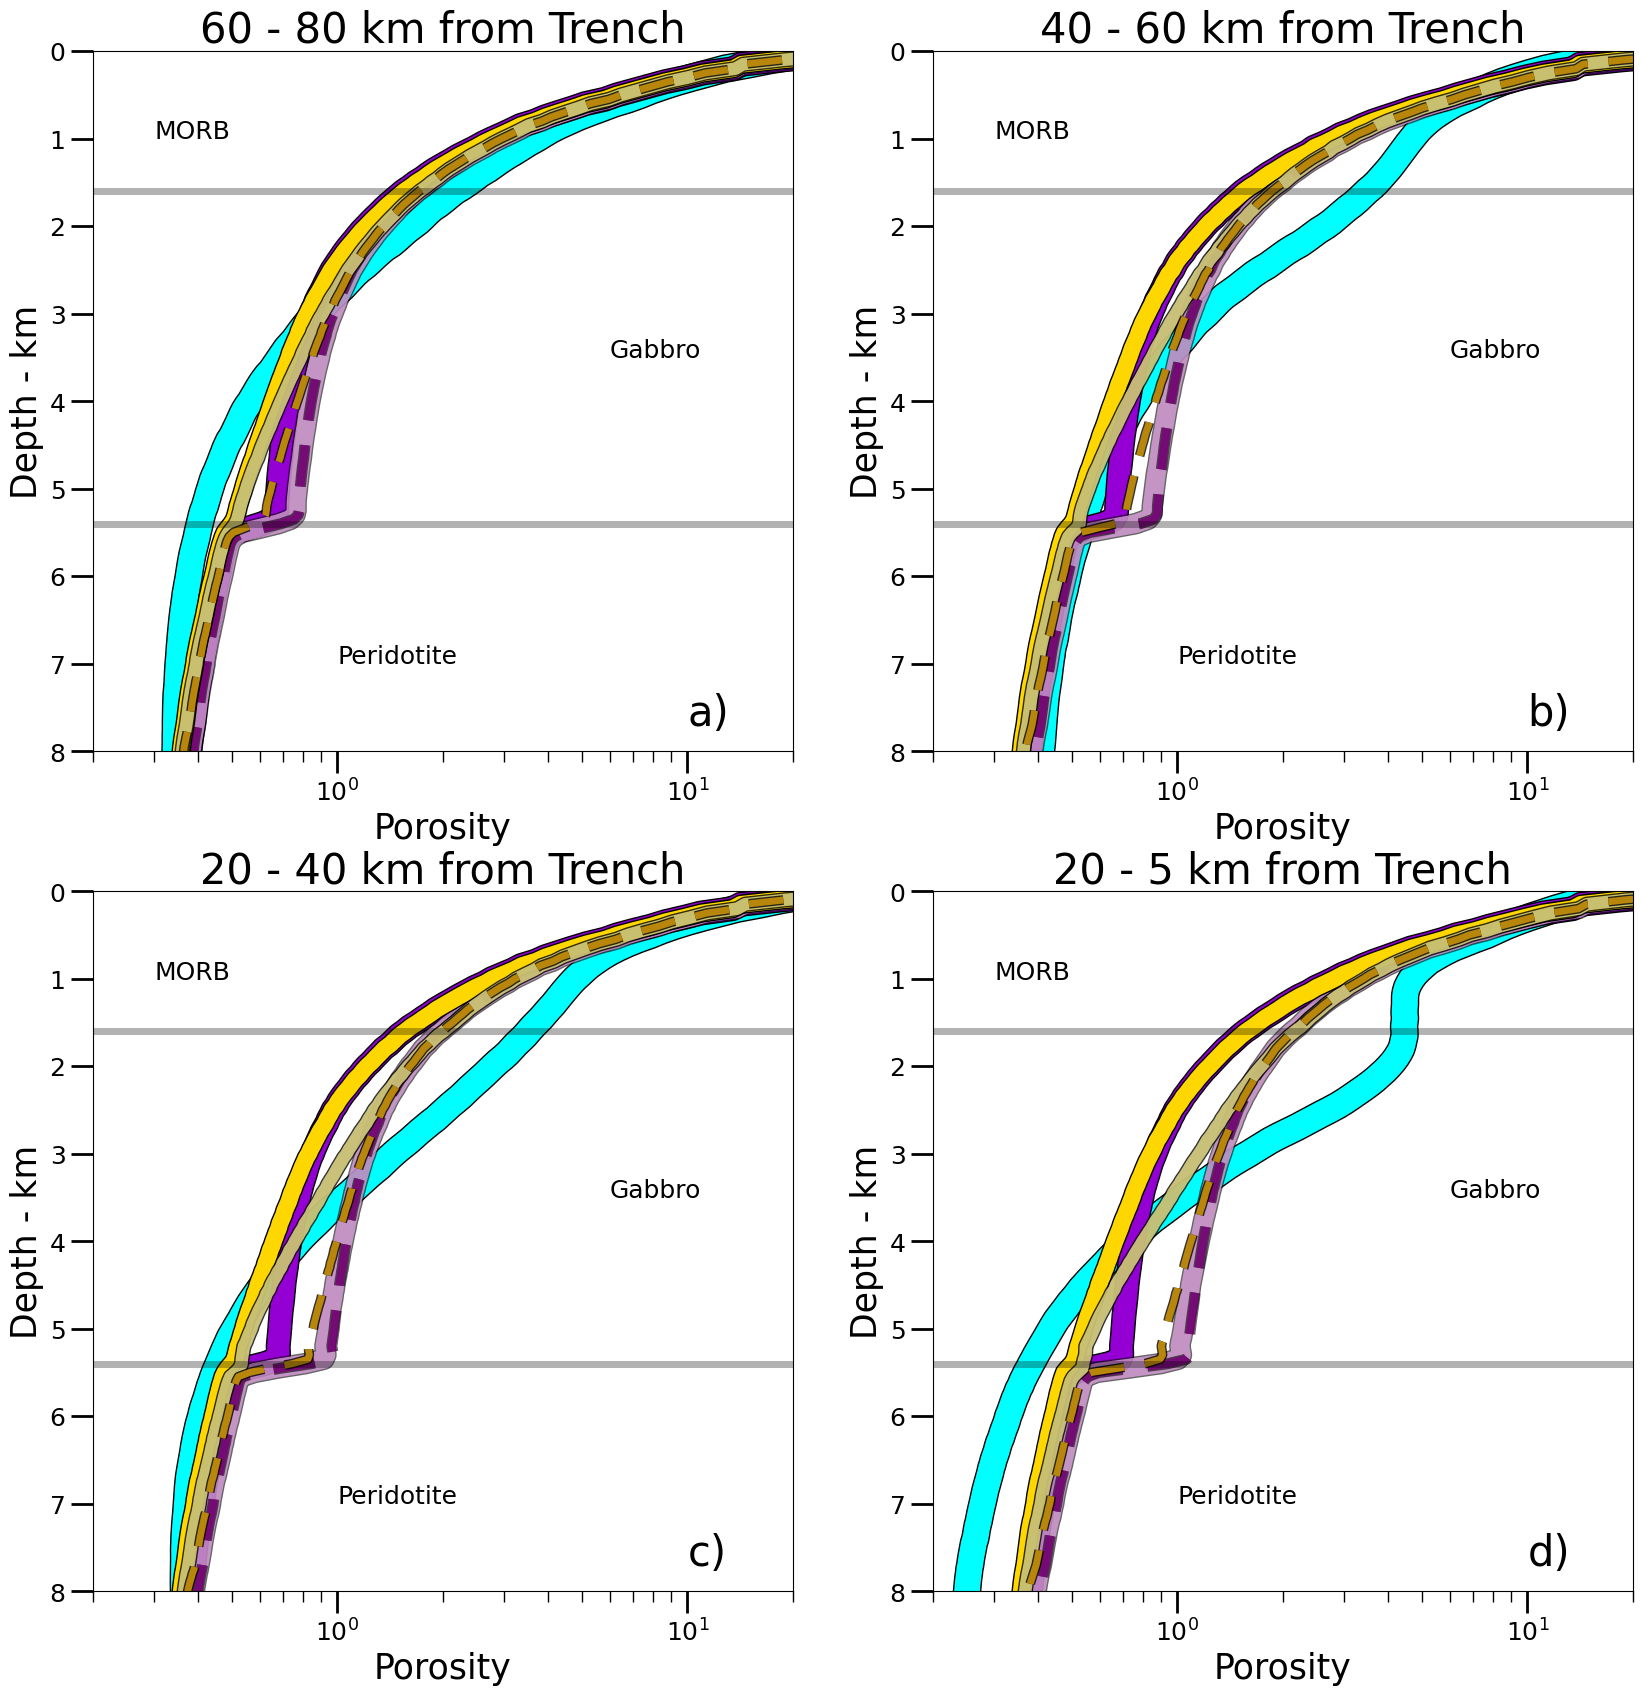

In [50]:
import matplotlib.patheffects as pe

box_width  = 7
box_height = 7
spacing    = 1.4
fig_size_x = 15
fig_size_y = 15

panel_A = [0, (box_height + spacing) / fig_size_y, box_width / fig_size_x, box_height / fig_size_y]
panel_B = [(box_width + spacing) / fig_size_x, (box_height + spacing) / fig_size_y, box_width / fig_size_x, box_height / fig_size_y]
panel_C = [0, 0, box_width / fig_size_x, box_height / fig_size_y]
panel_D = [(box_width + spacing) / fig_size_x, 0, box_width / fig_size_x, box_height / fig_size_y]

fig = plt.figure(dpi=100, figsize=(fig_size_x, fig_size_y))
ax_A = fig.add_axes(panel_A)
ax_B = fig.add_axes(panel_B)
ax_C = fig.add_axes(panel_C)
ax_D = fig.add_axes(panel_D)

ax_A.set_ylim(0, 8)
ax_B.set_ylim(0, 8)
ax_C.set_ylim(0, 8)
ax_D.set_ylim(0, 8)

ax_A.set_xlim(0.2, 20)
ax_B.set_xlim(0.2, 20)
ax_C.set_xlim(0.2, 20)
ax_D.set_xlim(0.2, 20)


ax_A.set_xscale("log")
ax_B.set_xscale("log")
ax_C.set_xscale("log")
ax_D.set_xscale("log")


ax_A.invert_yaxis()
ax_B.invert_yaxis()
ax_C.invert_yaxis()
ax_D.invert_yaxis()

ax_A.set_title("60 - 80 km from Trench", fontsize=30)
ax_B.set_title("40 - 60 km from Trench", fontsize=30)
ax_C.set_title("20 - 40 km from Trench", fontsize=30)
ax_D.set_title("20 - 5 km from Trench", fontsize=30)

ax_A.set_xlabel("Porosity", fontsize=25)
ax_B.set_xlabel("Porosity", fontsize=25)
ax_C.set_xlabel("Porosity", fontsize=25)
ax_D.set_xlabel("Porosity", fontsize=25)

ax_A.set_ylabel("Depth - km", fontsize=25)
ax_B.set_ylabel("Depth - km", fontsize=25)
ax_C.set_ylabel("Depth - km", fontsize=25)
ax_D.set_ylabel("Depth - km", fontsize=25)

ax_A.tick_params(labelsize=18, length=16, width=2)
ax_B.tick_params(labelsize=18, length=16, width=2)
ax_C.tick_params(labelsize=18, length=16, width=2)
ax_D.tick_params(labelsize=18, length=16, width=2)

ax_A.tick_params(labelsize=18, length=8, width=1, which="minor")
ax_B.tick_params(labelsize=18, length=8, width=1, which="minor")
ax_C.tick_params(labelsize=18, length=8, width=1, which="minor")
ax_D.tick_params(labelsize=18, length=8, width=1, which="minor")

###################### NOW PLOT THE CURVES ######################
# 1 is for no faults, 3 is for 2.5x, 4 is for 5x, 5 is for 7.5x, 6 is for 10x, 7 is for 25x
no_flexure_index = 0
flexure_index    = 2
faults_index     = 7
a_val = 0.8

ax_A.plot(depth_averaged_por[3]*100, z_vals_for_bins, c='black', lw=20.5)
ax_B.plot(depth_averaged_por[2]*100, z_vals_for_bins, c='black', lw=20.5)
ax_C.plot(depth_averaged_por[1]*100, z_vals_for_bins, c='black', lw=20.5)
ax_D.plot(depth_averaged_por[0]*100, z_vals_for_bins, c='black', lw=20.5)

ax_A.plot(depth_averaged_por[3]*100, z_vals_for_bins, c='cyan', lw=18.5)
ax_B.plot(depth_averaged_por[2]*100, z_vals_for_bins, c='cyan', lw=18.5)
ax_C.plot(depth_averaged_por[1]*100, z_vals_for_bins, c='cyan', lw=18.5)
ax_D.plot(depth_averaged_por[0]*100, z_vals_for_bins, c='cyan', lw=18.5)

##############################################################################################################################

ax_A.plot(depth_averages_for_models_kj[no_flexure_index][3]*100, z_vals_for_bins, c='black', lw=18, ls='-')
ax_B.plot(depth_averages_for_models_kj[no_flexure_index][2]*100, z_vals_for_bins, c='black', lw=18, ls='-')
ax_C.plot(depth_averages_for_models_kj[no_flexure_index][1]*100, z_vals_for_bins, c='black', lw=18, ls='-')
ax_D.plot(depth_averages_for_models_kj[no_flexure_index][0]*100, z_vals_for_bins, c='black', lw=18, ls='-')

ax_A.plot(depth_averages_for_models_kj[no_flexure_index][3]*100, z_vals_for_bins, c='darkviolet', lw=16, ls='-')
ax_B.plot(depth_averages_for_models_kj[no_flexure_index][2]*100, z_vals_for_bins, c='darkviolet', lw=16, ls='-')
ax_C.plot(depth_averages_for_models_kj[no_flexure_index][1]*100, z_vals_for_bins, c='darkviolet', lw=16, ls='-')
ax_D.plot(depth_averages_for_models_kj[no_flexure_index][0]*100, z_vals_for_bins, c='darkviolet', lw=16, ls='-')

##############################################################################################################################
ax_A.plot(depth_averages_for_models_kj[flexure_index][3]*100, z_vals_for_bins, c='plum', linestyle='-', lw=13.5,
          path_effects=[pe.Stroke(linewidth=15.5, foreground='black', alpha=a_val-0.2), pe.Normal()], alpha=a_val)
ax_B.plot(depth_averages_for_models_kj[flexure_index][2]*100, z_vals_for_bins, c='plum', linestyle='-', lw=13.5,
          path_effects=[pe.Stroke(linewidth=15.5, foreground='black', alpha=a_val-0.2), pe.Normal()], alpha=a_val)
ax_C.plot(depth_averages_for_models_kj[flexure_index][1]*100, z_vals_for_bins, c='plum', linestyle='-', lw=13.5,
          path_effects=[pe.Stroke(linewidth=15.5, foreground='black', alpha=a_val-0.2), pe.Normal()], alpha=a_val)
ax_D.plot(depth_averages_for_models_kj[flexure_index][0]*100, z_vals_for_bins, c='plum', linestyle='-', lw=13.5,
          path_effects=[pe.Stroke(linewidth=15.5, foreground='black', alpha=a_val-0.2), pe.Normal()], alpha=a_val)

##############################################################################################################################
ax_A.plot(depth_averages_for_models_kj[faults_index][3]*100, z_vals_for_bins, c='purple', linestyle=(0, (5, 3)), lw=6,
          path_effects=[pe.Stroke(linewidth=8, foreground='black', alpha=a_val-0.2), pe.Normal()], alpha=a_val)
ax_B.plot(depth_averages_for_models_kj[faults_index][2]*100, z_vals_for_bins, c='purple', linestyle=(0, (5, 3)), lw=6,
          path_effects=[pe.Stroke(linewidth=8, foreground='black', alpha=a_val-0.2), pe.Normal()], alpha=a_val)
ax_C.plot(depth_averages_for_models_kj[faults_index][1]*100, z_vals_for_bins, c='purple', linestyle=(0, (5, 3)), lw=6,
          path_effects=[pe.Stroke(linewidth=8, foreground='black', alpha=a_val-0.2), pe.Normal()], alpha=a_val)
ax_D.plot(depth_averages_for_models_kj[faults_index][0]*100, z_vals_for_bins, c='purple', linestyle=(0, (5, 3)), lw=6,
          path_effects=[pe.Stroke(linewidth=8, foreground='black', alpha=a_val-0.2), pe.Normal()], alpha=a_val)

##############################################################################################################################

ax_A.plot(depth_averages_for_models_ha[no_flexure_index][3]*100, z_vals_for_bins, c='black', lw=14)
ax_B.plot(depth_averages_for_models_ha[no_flexure_index][2]*100, z_vals_for_bins, c='black', lw=14)
ax_C.plot(depth_averages_for_models_ha[no_flexure_index][1]*100, z_vals_for_bins, c='black', lw=14)
ax_D.plot(depth_averages_for_models_ha[no_flexure_index][0]*100, z_vals_for_bins, c='black', lw=14)

ax_A.plot(depth_averages_for_models_ha[no_flexure_index][3]*100, z_vals_for_bins, c='gold', lw=12)
ax_B.plot(depth_averages_for_models_ha[no_flexure_index][2]*100, z_vals_for_bins, c='gold', lw=12)
ax_C.plot(depth_averages_for_models_ha[no_flexure_index][1]*100, z_vals_for_bins, c='gold', lw=12)
ax_D.plot(depth_averages_for_models_ha[no_flexure_index][0]*100, z_vals_for_bins, c='gold', lw=12)

##############################################################################################################################
ax_A.plot(depth_averages_for_models_ha[flexure_index][3]*100, z_vals_for_bins, c='khaki', linestyle='-', lw=9,
          path_effects=[pe.Stroke(linewidth=11, foreground='black', alpha=a_val), pe.Normal()], alpha=a_val)
ax_B.plot(depth_averages_for_models_ha[flexure_index][2]*100, z_vals_for_bins, c='khaki', linestyle='-', lw=9,
          path_effects=[pe.Stroke(linewidth=11, foreground='black', alpha=a_val), pe.Normal()], alpha=a_val)
ax_C.plot(depth_averages_for_models_ha[flexure_index][1]*100, z_vals_for_bins, c='khaki', linestyle='-', lw=9,
          path_effects=[pe.Stroke(linewidth=11, foreground='black', alpha=a_val), pe.Normal()], alpha=a_val)
ax_D.plot(depth_averages_for_models_ha[flexure_index][0]*100, z_vals_for_bins, c='khaki', linestyle='-', lw=9,
          path_effects=[pe.Stroke(linewidth=11, foreground='black', alpha=a_val), pe.Normal()], alpha=a_val)

##############################################################################################################################
ax_A.plot(depth_averages_for_models_ha[faults_index][3]*100, z_vals_for_bins, c='darkgoldenrod', linestyle=(0, (5, 3)), lw=5,
          path_effects=[pe.Stroke(linewidth=7, foreground='black', alpha=a_val), pe.Normal()], alpha=1)
ax_B.plot(depth_averages_for_models_ha[faults_index][2]*100, z_vals_for_bins, c='darkgoldenrod', linestyle=(0, (5, 3)), lw=5,
          path_effects=[pe.Stroke(linewidth=7, foreground='black', alpha=a_val), pe.Normal()], alpha=1)
ax_C.plot(depth_averages_for_models_ha[faults_index][1]*100, z_vals_for_bins, c='darkgoldenrod', linestyle=(0, (5, 3)), lw=5,
          path_effects=[pe.Stroke(linewidth=7, foreground='black', alpha=a_val), pe.Normal()], alpha=1)
ax_D.plot(depth_averages_for_models_ha[faults_index][0]*100, z_vals_for_bins, c='darkgoldenrod', linestyle=(0, (5, 3)), lw=5,
          path_effects=[pe.Stroke(linewidth=7, foreground='black', alpha=a_val), pe.Normal()], alpha=1)

ax_A.axhline(1.6, ls='-', c='k', alpha=0.3, lw=5)
ax_B.axhline(1.6, ls='-', c='k', alpha=0.3, lw=5)
ax_C.axhline(1.6, ls='-', c='k', alpha=0.3, lw=5)
ax_D.axhline(1.6, ls='-', c='k', alpha=0.3, lw=5)

ax_A.axhline(5.4, ls='-', c='k', alpha=0.3, lw=5)
ax_B.axhline(5.4, ls='-', c='k', alpha=0.3, lw=5)
ax_C.axhline(5.4, ls='-', c='k', alpha=0.3, lw=5)
ax_D.axhline(5.4, ls='-', c='k', alpha=0.3, lw=5)

ax_A.text(10, 7.7, "a)", fontsize=30)
ax_B.text(10, 7.7, "b)", fontsize=30)
ax_C.text(10, 7.7, "c)", fontsize=30)
ax_D.text(10, 7.7, "d)", fontsize=30)

ax_A.text(0.3, 1.0, "MORB", fontsize=18)
ax_A.text(6, 3.5, "Gabbro", fontsize=18)
ax_A.text(1.0, 7.0, "Peridotite", fontsize=18)

ax_B.text(0.3, 1.0, "MORB", fontsize=18)
ax_B.text(6, 3.5, "Gabbro", fontsize=18)
ax_B.text(1.0, 7.0, "Peridotite", fontsize=18)

ax_C.text(0.3, 1.0, "MORB", fontsize=18)
ax_C.text(6, 3.5, "Gabbro", fontsize=18)
ax_C.text(1.0, 7.0, "Peridotite", fontsize=18)

ax_D.text(0.3, 1.0, "MORB", fontsize=18)
ax_D.text(6, 3.5, "Gabbro", fontsize=18)
ax_D.text(1.0, 7.0, "Peridotite", fontsize=18)

plt.savefig("Figures/figure_3.png", bbox_inches="tight")
plt.show()